In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats

np.random.seed(27);
torch.manual_seed(27);

In [2]:
import logging
logging.getLogger().setLevel(logging.DEBUG)

%load_ext autoreload
%autoreload 2

In [3]:
DEVICE = 'cuda'
NDIM = 2

## Torus model

In [4]:
def model(v):
    x = v
    return dict(x=x)

def noise(sim, v):
    x = sim['x'] + np.random.randn(NDIM)*0.1
    return dict(x=x)

In [5]:
v0 = np.zeros(NDIM)
obs0 = model(v0)
obs0, v0

({'x': array([0., 0.])}, array([0., 0.]))

In [6]:
prior = swyft.Prior.from_uv(lambda u: u-0.5, NDIM)

In [7]:
simulator = swyft.Simulator(model, sim_shapes = dict(x=(NDIM,)))
store = swyft.MemoryStore(NDIM, simulator = simulator)

DEBUG:root:Creating new empty MemoryStore.
DEBUG:root:  params = ['z0', 'z1']
INFO:root:Creating new store.
DEBUG:root:  sim_shapes = {'x': (2,)}


In [8]:
partitions = list(range(NDIM))
micro = swyft.Microscope(partitions, prior, obs0, store = store, simhook = noise, device = DEVICE, Ninit = 10000, train_args = dict(nworkers = 4))

In [10]:
micro.focus(max_rounds=1)

INFO:root:Starting round 1
DEBUG:root:Step 0: Initializing dataset for round 1
DEBUG:root:  dataset size N = 10000
INFO:root:  adding 9979 new samples to simulator store.
DEBUG:root:Step 1: Perform simulations for round 1
DEBUG:root:Step 1: Perform simulations for round 1
DEBUG:root:Step 2: Training for round 1
DEBUG:root:Initializing swyft.Module with tag `DefaultHead`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'x': torch.Size([2])}, 'obs_transform': None, 'online_norm': True}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(2, [(0,), (1,)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:  combinations = None
DEBUG:root:  batch_size = 32
DEBUG:root:  nworkers = 4
DEBUG:root:  max_epochs = 10
DEBUG:root:  early_stopping_patience = 1
DEBUG:root:  lr_schedule = [0.001, 0.0003, 0.0

In [11]:
post = swyft.Posteriors.from_Microscope(micro)

In [12]:
samples = post.sample(1000000, obs0)

In [39]:
entropy = [v['entropy'] for v in swyft.utils.sample_diagnostics(samples, true_posteriors = {}).values()]
print(entropy)
stats.norm.entropy(0., 0.1)

[-0.9330768577160696, -0.9034404513548838]


array(-0.88364656)

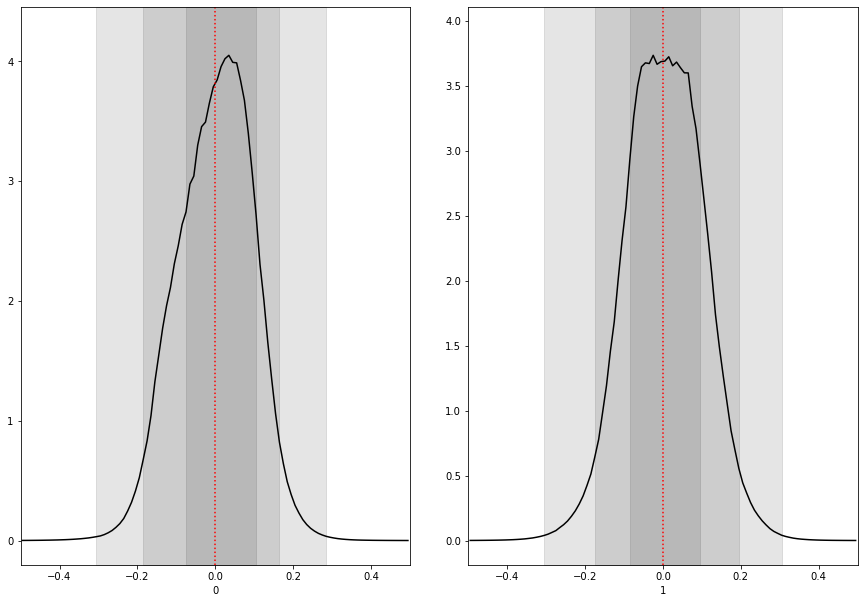

In [40]:
swyft.plot1d(samples, [0, 1], ncol = 2, truth = v0)

In [41]:
Ninit = 50000

In [25]:
micro2 = swyft.Microscope(partitions, prior, obs0, store = store, simhook = noise, device = DEVICE, Ninit = Ninit)
micro2.focus(max_rounds=1)

INFO:root:Starting round 1
DEBUG:root:Step 0: Initializing dataset for round 1
DEBUG:root:  dataset size N = 50000
INFO:root:  adding 6233 new samples to simulator store.
DEBUG:root:Step 1: Perform simulations for round 1
DEBUG:root:Step 1: Perform simulations for round 1
DEBUG:root:Step 2: Training for round 1
DEBUG:root:Initializing swyft.Module with tag `DefaultHead`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'x': torch.Size([10])}, 'obs_transform': None, 'online_norm': True}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(10, [(0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:  combinations = None
DEBUG:root:  batch_size = 32
DEBUG:root:  nworkers = 0
DEBUG:root:  max_epochs = 10
DEBUG:root:  early_stopping_patience 

In [26]:
post2 = swyft.Posteriors.from_Microscope(micro2)
samples2 = post2.sample(1000000, obs0)

In [27]:
entropy2 = [v['entropy'] for v in swyft.utils.sample_diagnostics(samples2).values()]
entropy2

/home/weniger/swyft/swyft/utils/utils.py:88: RuntimeWarning: divide by zero encountered in log
  entropy = -simps(y_int * np.log(y_int), x_int)
/home/weniger/swyft/swyft/utils/utils.py:88: RuntimeWarning: invalid value encountered in multiply
  entropy = -simps(y_int * np.log(y_int), x_int)


[-2.9002529088310274,
 -1.2000625864042511,
 -3.4493960525389875,
 -3.7363388004579043,
 -2.0621877765475043,
 -2.3082450417896663,
 -1.525521528036245,
 nan,
 -2.1686727391613885,
 -1.8302151867688496]

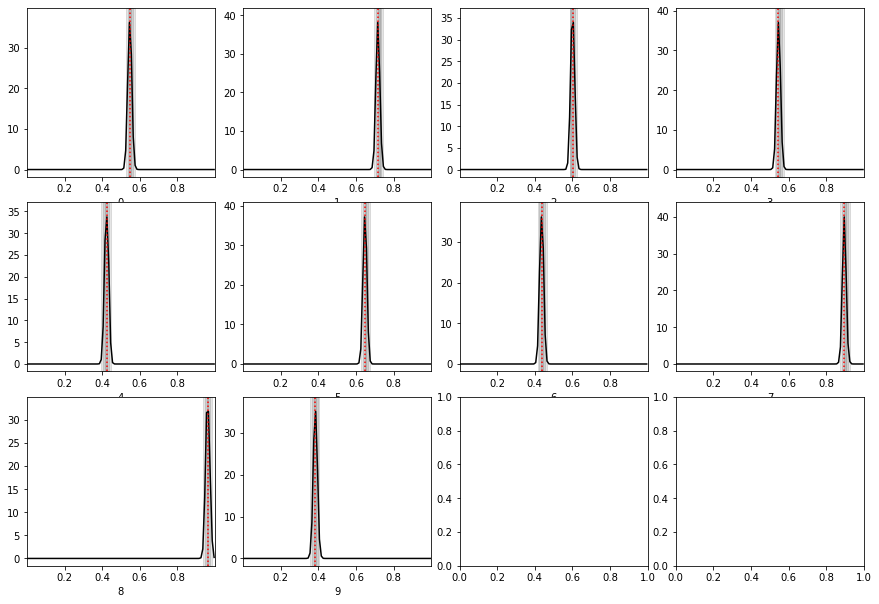

In [28]:
swyft.plot1d(samples2, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ncol = 4, truth = v0)

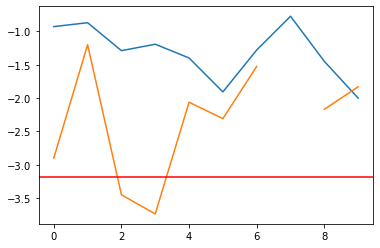

In [30]:
plt.plot(entropy)
plt.plot(entropy2)
import scipy.stats
entropy_true = scipy.stats.norm.entropy(0., 0.01)
plt.axhline(entropy_true, color='r')